Testing Sentence Similarity

In [1]:
from absl import logging

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns


### Download Universal Sentence Encoder 

In [2]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)


module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [9]:
from nltk import tokenize
import nltk
nltk.download('punkt')
sentences = []
sent_count = []
for idx in range(3):
    sentences += tokenize.sent_tokenize(open(f"resources/filtered/{idx}.txt",encoding="utf-8").read())
    sent_count.append(len(sentences))

non_empty = [sentence for sentence in sentences if len(sentence) > 0]
logging.set_verbosity(logging.ERROR)

vectors = embed(non_empty)


[nltk_data] Downloading package punkt to /home/andrew/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [10]:
from sklearn import metrics
num_sent = np.shape(vectors)[0]
cosine = metrics.pairwise.cosine_similarity(vectors)
## kill off the diagonal
np.fill_diagonal(cosine, 0.0)
# maxes = np.amax(cosine, 1)
maxes = np.amax(cosine, 1)
argmaxes = np.argmax(cosine, 1)
#print(maxes)



# Exploring Cosine Similarity

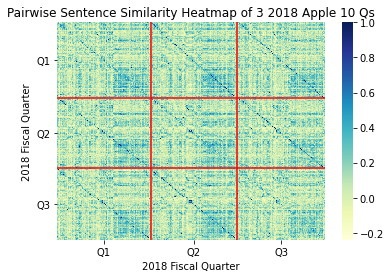

In [11]:
# %matplotlib ipympl

sns.heatmap(cosine,cmap="YlGnBu")
plt.axhline(sent_count[0],color='red')
plt.axhline(sent_count[1],color='red')
plt.axvline(sent_count[0],color='red')
plt.axvline(sent_count[1], color='red')

plt.title("Pairwise Sentence Similarity Heatmap of 3 2018 Apple 10 Qs")
plt.xlabel("2018 Fiscal Quarter")
plt.ylabel("2018 Fiscal Quarter")
plt.xticks([sent_count[0]/2,sent_count[1] - (sent_count[1]-sent_count[0])/2,\
            sent_count[2]- (sent_count[2]- sent_count[1])/2],["Q1","Q2","Q3"],\
          rotation="horizontal")
plt.yticks([sent_count[0]/2,sent_count[1] - (sent_count[1]-sent_count[0])/2,\
            sent_count[2]- (sent_count[2]- sent_count[1])/2],["Q1","Q2","Q3"],\
          rotation="horizontal")
plt.show()


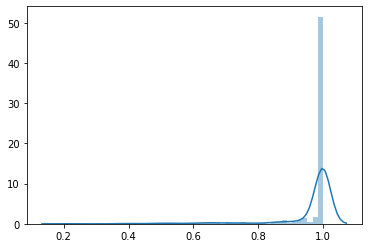

In [12]:
## plot histogram 
idcs = range(num_sent)
sns.distplot(maxes)
# seaborn.scatterplot(list(range(num_sent)), maxes)
plt.show()

In [13]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
@interact
def show_sent_below_thresh(thr=(min(maxes),max(maxes),.01),show_plot=True):
    below_thresh = np.where(maxes < thr)
    if show_plot == True:
        sns.distplot(maxes)
        plt.axvline(thr,c="red")

        plt.title("Histogram of max sentence correllations")
        plt.xlabel("Cosine Similarity")
        plt.ylabel("Frequency (%)")
        plt.show()
    # print(below_thresh)
    print(f"First 20 sentences with max cosine similarity below {thr:.2f}:")
    counter = 0
    for low in below_thresh[0][:20]:
        if len(sentences[low])>1:
            counter += 1
            print(f"Sentence {counter}.", sentences[low])
            print(f"Most Similar Sentence:", sentences[argmaxes[low]])
            print()
    return (below_thresh[0])



interactive(children=(FloatSlider(value=0.2055625319480896, description='thr', max=1.0000005960464478, min=0.2…

## t-SNE visualizations

In [14]:
from sklearn.manifold import TSNE

tsne_embed = TSNE(n_components=2).fit_transform(vectors)
tsne_embed.shape

(1213, 2)

In [15]:
from matplotlib import cm
@interact
def create_USE_tsne(max_quantile = (0,1,.1)):
    plt.clf()
    fig,ax = plt.subplots()
    legend = list()
    for sec in range(int(max_quantile*10)):
        idxs = np.where(np.logical_and(maxes > np.quantile(maxes, .1*sec), maxes < np.quantile(maxes, .1+.1*sec)))[0]
        ax.scatter(tsne_embed[idxs,0],tsne_embed[idxs,1],color=cm.nipy_spectral(.2+.08*sec))
        legend.append(f"{np.quantile(maxes, .1*sec):.2f} - { np.quantile(maxes, .1+.1*sec):.2f}")
    plt.legend(legend,loc ="upper left", bbox_to_anchor=[1,1])    
    plt.title("t-SNE of USE vectors cosine similarity, in quantiles")
    plt.show()


interactive(children=(FloatSlider(value=0.0, description='max_quantile', max=1.0), Output()), _dom_classes=('w…